In [20]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os
import sys

dir_path = os.path.abspath('')
sys.path.append(dir_path + '/../')

from interpolazione import Interpolazione, final_val

dir_path = os.path.abspath('')
FILE = dir_path + '/data/' + 'RC.csv'
fr = pd.read_csv(FILE)

V = np.array(fr['V (V)'])
t = np.array(fr['t (us)']) * 10**-6
R = 996 # 10%
sigmaR = 0.1 * R
T = 2* (10**-3) # 2ms
sigmaV = 0.2 / np.sqrt(12)#  0.08 / np.sqrt(12) # uniform distribution
# Vg = 4.95 # V

$
V_r(t) = \frac{2V_g}{{1 + e^{-\frac{T}{2\tau}}}}e^{-\frac{t}{\tau}} 
$

where $\tau = R \cdot C$

In [28]:
def VR(t, τ, Vg):
    return 2*Vg*np.exp(-t/τ)/(1+np.exp(-T/(2*τ)))

C_guess = 99 * 10**-9 # 0.1 nF
Vg_guess = 4.95
i = Interpolazione(t,V,VR, sigmaV, p0=[R*C_guess, Vg_guess])
print(i)

print('----------------------- RESULT -----------------------')
# estrazione dei valori di C e Vg
Vg = i.bval[1]
sigmaVg = i.sigma_bval[1]
τ = i.bval[0]
sigmaτ = i.sigma_bval[0]

C = τ / R
sigmaC = np.sqrt((sigmaτ / R)**2 + (τ * sigmaR / R**2)**2)

print(final_val(C, sigmaC,exp=-9,decimals=0,udm='F'))
print(final_val(Vg, sigmaVg,decimals=2,udm='V'))

   
Parameters: [1.04232457e-04 4.70030682e+00] 
Sigma parameters: [2.78747074e-07 8.34646896e-03]

sigmaY: 0.05773502691896258

chiquadro ridotto: 0.23
df: 40
pvalue: 100.0%
covariance matrix: [[ 7.04761281e-14 -1.53025138e-09]
 [-1.53025138e-09  6.31868881e-05]]    

----------------------- RESULT -----------------------
(105.0 ± 10.0)e-9 F
4.7 ± 0.01 V


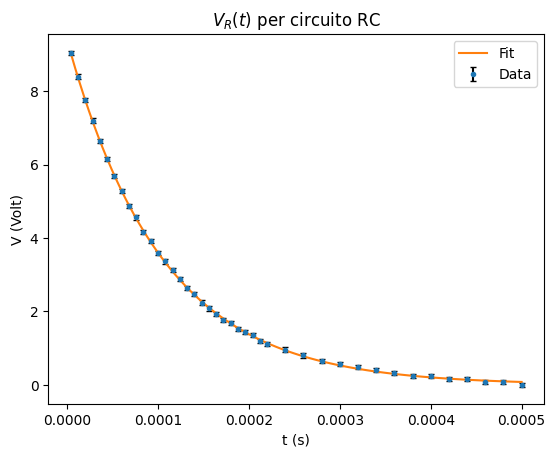

In [25]:
plt.errorbar(t, V, yerr=sigmaV, fmt='.',ecolor='black',label='Data',capsize=2)
plt.plot(i.x_best,i.y_best,label='Fit')

plt.xlabel('t (s)')
plt.ylabel('V (Volt)')
plt.title('$V_R(t)$ per circuito RC')
plt.legend()
plt.show()

$
V_c(t) = V_g - V_r
$

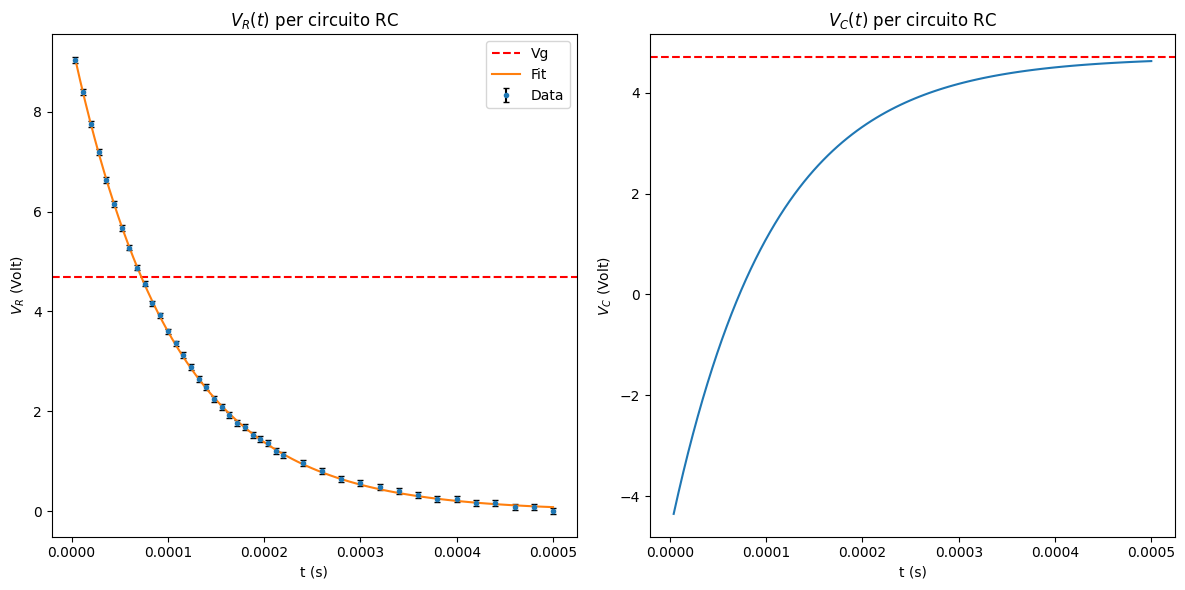

In [29]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot on the left
ax1.axhline(y=Vg, color='r', linestyle='--', label='Vg')
ax1.errorbar(t, V, yerr=sigmaV, fmt='.', ecolor='black', label='Data', capsize=2)
ax1.plot(i.x_best, i.y_best, label='Fit')
ax1.set_xlabel('t (s)')
ax1.set_ylabel('$V_R$ (Volt)')
ax1.set_title('$V_R(t)$ per circuito RC')
ax1.legend()

# Plot on the right
V_c = Vg - i.y_best
ax2.axhline(y=Vg, color='r', linestyle='--', label='Vg')
ax2.plot(i.x_best, V_c)
ax2.set_xlabel('t (s)')
ax2.set_ylabel('$V_C$ (Volt)')
ax2.set_title('$V_C(t)$ per circuito RC')

plt.tight_layout()
plt.show()

## CONFRONTO CON VALORI ATTESI

τ_fit = (9.8471 ± 0.0845)e-5 s
τ_att = (9.8604 ± 0.9911)e-5 s
τ =  (9.8472 ± 0.0842)e-5 s


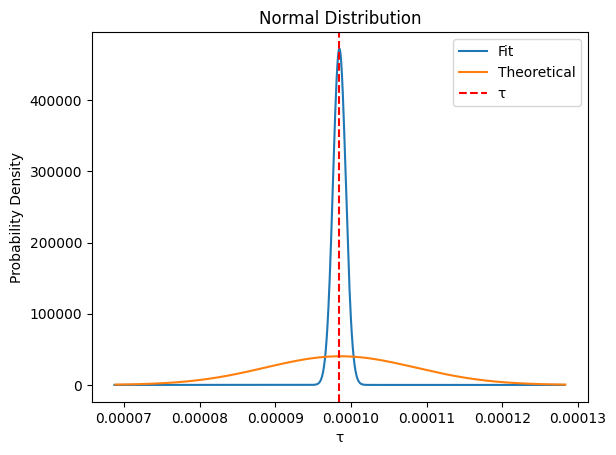

In [11]:
τ_fit = i.bval[0] # fit
sfit = i.sigma_bval[0] # fit sigma
τ_att = R*C # teorico
satt = np.sqrt((sigmaR*C)**2 + (sigmaC*R)**2) # teorico sigma
# valore medio:
τ = np.average([τ_fit, τ_att], weights=[1/sfit**2, 1/satt**2])
sigmaτ = 1/np.sqrt(1/sfit**2 + 1/satt**2)


print('τ_fit =', final_val(τ_fit, sfit,4,-5,'s'))
print('τ_att =', final_val(τ_att, satt,4,-5,'s'))
print('τ = ',final_val(τ, sigmaτ,4,-5,'s'))


# Parameters
x_fit = np.linspace(τ_fit - 3*satt, τ_fit + 3*satt, 1000)
y_fit = (1 / (sfit * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - τ_fit) / sfit) ** 2)

x_att = np.linspace(τ_att - 3*satt, τ_att + 3*satt, 1000)
y_att = (1 / (satt * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x_att - τ_att) / satt) ** 2)

x = np.linspace(τ - 3*satt, τ + 3*satt, 1000)
y = (1 / (sigmaτ * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - τ) / sigmaτ) ** 2)

# Plotting
plt.plot(x_fit, y_fit, label='Fit')
plt.plot(x_att, y_att, label='Theoretical')

plt.axvline(x=τ, color='r', linestyle='--', label='τ')

# plt.plot(x, y, label='average')

plt.xlabel('τ')
plt.ylabel('Probability Density')
plt.title('Normal Distribution')
plt.legend()
plt.show()